# Dynamic factor model

This notebook replicates [Stock, J. H., & Watson, M. W. (2016). Dynamic factor models, factor-augmented vector autoregressions, and structural vector autoregressions in macroeconomics. In Handbook of macroeconomics (Vol. 2, pp. 415-525). Elsevier.](https://www.sciencedirect.com/science/article/pii/S1574004816300027)

written by [Shunsuke-Hori](https://github.com/Shunsuke-Hori)

**NOTE**: This project is still under progress. You can find the code for this notebook in [this repository](https://github.com/QuantEcon/dynamic_factor_models). Any contribution is welcome and appreciated.

In [1]:
using NBInclude

In [2]:
include("readin_functions.jl");

@nbinclude("dfm_functions.ipynb");

In [3]:
using Plots
pyplot() # any backend is fine though
using StatPlots # for grouped bar plot
using LaTeXStrings
using Millboard # for table
using Distributions

In [4]:
using Pkg
pkg"status"

    Status `C:\Users\holly\.julia\environments\v1.0\Project.toml`
  [28f2ccd6] ApproxFun v0.10.3
  [336ed68f] CSV v0.4.3
  [60f91f6f] CovarianceMatrices v0.9.0
  [a93c6f00] DataFrames v0.15.2
  [0c46a032] DifferentialEquations v5.3.1
  [31c24e10] Distributions v0.16.4
  [c04bee98] ExcelReaders v0.10.2
  [38e38edf] GLM v1.0.2
  [28b8d3ca] GR v0.36.0
  [7073ff75] IJulia v1.14.1
  [f4508453] InfoZIP v0.2.0
  [a98d9a8b] Interpolations v0.11.0
  [b6b21f68] Ipopt v0.4.4
  [033835bb] JLD2 v0.1.2
  [4076af6c] JuMP v0.18.5
  [b964fa9f] LaTeXStrings v1.0.3
  [94d9927c] LaTeXTabulars v0.0.0 #master (https://github.com/tpapp/LaTeXTabulars.jl)
  [23fbe1c1] Latexify v0.6.0
  [0fc2ff8b] LeastSquaresOptim v0.7.1
  [2fda8390] LsqFit v0.6.0
  [10e44e05] MATLAB v0.7.2
  [39ec1447] Millboard v0.2.0
  [6f286f6a] MultivariateStats v0.6.0
  [0db19996] NBInclude v2.1.0
  [76087f3c] NLopt v0.5.1
  [2774e3e8] NLsolve v3.0.1
  [429524aa] Optim v0.17.2
  [d96e819e] Parameters v0.10.3
  [91a5bcdd] Plots v0.22.0
  

##### Duration of data

In [5]:
md = MonthlyData((1959, 1), (2014, 12), 148)
qd = QuarterlyData((1959, 1), (2014, 4), 85)

QuarterlyData(224, 85)

##### Read real data

In [6]:
dataset = readin_data(md, qd, BiWeight(100), :Real);

year = dataset.calvec
data = dataset.bpdata
inclcode = dataset.inclcode;

##### Real all data

In [7]:
dataset_all = readin_data(md, qd, BiWeight(100), :All);
year_all = dataset_all.calvec
data_all = dataset_all.bpdata
inclcode_all = dataset_all.inclcode;

# Figure 1

##### Initial and last period of sample to be used in estimation

In [8]:
initperiod = find_row_number((1959, 3), dataset.calds) # first two quarters are dropped
lastperiod = find_row_number((2014, 4), dataset.calds)

224

##### Benchmark parameters

In [9]:
nt_min_factor_estimation = 20 # min number of obs for any series used to est factors
nt_min_factorloading_estimation = 40 # min number of obs for any series used to estimate lamba, irfs, etc.
nfac_o = 0 # number of observed factors
nfac_u = 1 # number of unobserved factors
n_uarlag = 4 # number of AR lags for uniqueness
n_factorlag = 4 # number of lags for factor evolution VAR
tol = 1e-8 # tolerance of NLS

1.0e-8

##### Construct DFMModel instance

In [10]:
dfmm = DFMModel(data, inclcode,
                nt_min_factor_estimation, nt_min_factorloading_estimation,
                initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag);

##### Estimate the DFM Model

In [11]:
estimate!(dfmm, NonParametric())

##### Functions for plotting

In [12]:
function plot_skipmissing!(p, x, y; args...)
    plot!(p, replace(x, missing=>NaN), replace(y, missing=>NaN); args...)
    return nothing
end
function plot_skipmissing(x, y; args...)
    p = plot()
    plot_skipmissing!(p, x, y; args...)
    return p
end

plot_skipmissing (generic function with 1 method)

In [13]:
function compare_series!(p, dfmm::DFMModel, namevec,
                          name, lab)
    i = findall(dataset.bpnamevec.==name)[1]
    yf = compute_series(dfmm, i)
    y4f = detrended_year_growth(yf)
    y4 = detrended_year_growth(dfmm.data[:, i])
    plot_skipmissing!(p, year, [100*y4 100*y4f], lw=2,
        lab=[lab "Common Component"], leg=:bottomleft)
    return p
end

compare_series! (generic function with 1 method)

##### Plot

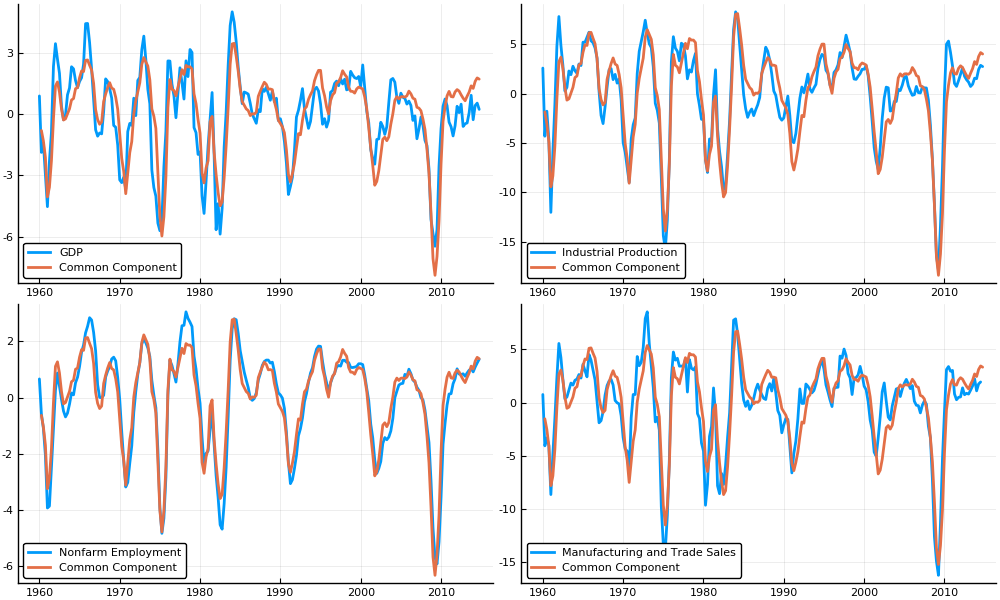

In [14]:
namevec = ["GDPC96","INDPRO","PAYEMS","A0M057"]
labvec = ["GDP", "Industrial Production",
            "Nonfarm Employment","Manufacturing and Trade Sales"]
p = plot(layout=(2,2), size=(1000,600))

for i in 1:4
    name, lab = namevec[i], labvec[i]
    compare_series!(p[i], dfmm, dataset.bpnamevec, name, lab)
end

p

# Figure 2

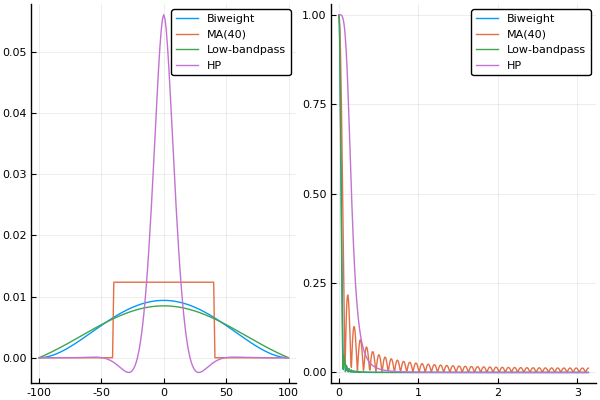

In [15]:
# lead and lag
maxlag = 100
laglead = -maxlag:maxlag
# Frequencies
wvec = range(0, stop=pi, length=500)

# Biweight filter
bw_para = maxlag
bw_weight = compute_bw_weight(bw_para)
# Compute Gain
bw_gain = [compute_gain(bw_weight, w) for w in wvec]

# MA filter: Flat over + and - 40 quarters
ma40_weight = abs.(laglead) .<= 40
ma40_weight = ma40_weight./sum(ma40_weight)
# Compute Gain
ma40_gain = [compute_gain(ma40_weight, w) for w in wvec]

# Band pass, 100 terms on each side, 200 quarter cutoff (Baxter-King)
nper = 2maxlag
ombar = 2pi/nper
t1 = 1:maxlag
tmp0 = ombar/pi
tmp1 = (1 ./ (pi*t1)).*sin.(t1*ombar)
bp_weight = vcat(tmp1[end:-1:1], tmp0, tmp1)
bp_weight = bp_weight/sum(bp_weight)
# Compute Gain
bp_gain = [compute_gain(bp_weight, w) for w in wvec]

# HP
hp_weight = vec(readdlm("data/hpfilter_trend.asc"))
# Compute Gain
hp_gain = [compute_gain(hp_weight, w) for w in wvec]

p = plot(layout=(1, 2))
labels = ["Biweight" "MA(40)" "Low-bandpass" "HP"]
plot!(p[1], laglead, [bw_weight ma40_weight bp_weight hp_weight], lab=labels)
plot!(p[2], wvec, [bw_gain ma40_gain bp_gain hp_gain], lab=labels)

# Figure 3

##### Divide sample

In [16]:
periods_all = ((1959, 3), (2014, 4))
periods_pre = ((1959, 3), (1983, 4))
periods_post = ((1984, 1), (2014, 4))

((1984, 1), (2014, 4))

##### Estimate DFM and get some statistic

In [17]:
periodss = (periods_all, periods_pre, periods_post)
max_nfac = 6
trace_r2 = Matrix{Float64}(undef, max_nfac, 3)
marg_r2 = Matrix{Float64}(undef, max_nfac, 3)
ah_er = Matrix{Float64}(undef, max_nfac, 3)
bin_ic = Matrix{Float64}(undef, max_nfac, 3)
for i = 1:3
    periods = periodss[i]
    initperiod = find_row_number(periods[1], dataset.calds)
    lastperiod = find_row_number(periods[2], dataset.calds)
    dfmm = DFMModel(data, inclcode,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)

    fnes = estimate_factor_numbers(dfmm, 1:max_nfac)

    trace_r2[:, i] = 1 .- fnes.ssr_static./fnes.tss

    marg_r2[1, i] = trace_r2[1, i]
    marg_r2[2:end, i] = trace_r2[2:end, i] - trace_r2[1:end-1, i]
    ah_er[1:max_nfac-1, i] = marg_r2[1:max_nfac-1, i]./marg_r2[2:max_nfac, i]
    bin_ic[:, i] = fnes.bn_icp
end

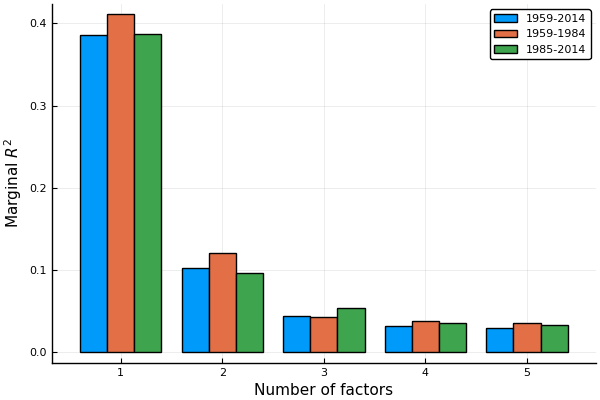

In [18]:
groupedbar(1:5, marg_r2[1:5, :], lab=["1959-2014" "1959-1984" "1985-2014"],
           bar_position = :dodge, grid=true, 
           xlab="Number of factors", ylab=L"Marginal $R^2$")

# Table 2

## (A) Real activity dataset ($N=558$ disaggregates used for estimating factors)

In [19]:
initperiod = find_row_number(periods_all[1], dataset.calds)
lastperiod = find_row_number(periods_all[2], dataset.calds)
dfmm = DFMModel(data, inclcode,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
max_nfac = 6
fnes = estimate_factor_numbers(dfmm, 1:max_nfac)

trace_r2 = 1 .- fnes.ssr_static./fnes.tss
marg_r2 = vcat(trace_r2[1], trace_r2[2:end] - trace_r2[1:end-1])
ah_er = marg_r2[1:max_nfac-1]./marg_r2[2:max_nfac]

table(round.([1:max_nfac-1 trace_r2[1:max_nfac-1] marg_r2[1:max_nfac-1] fnes.bn_icp[1:max_nfac-1] ah_er], digits=3),
      colnames=hcat("Number of\nstatic factors", "Trace R2", "Marginal\ntrace R2", "BN-ICp2", "AH-ER"))

|   |      Number of | Trace R2 | Marginal | BN-ICp2 | AH-ER |
|   | static factors |          | trace R2 |         |       |
|---|----------------|----------|----------|---------|-------|
| 1 |            1.0 |    0.385 |    0.385 |  -0.398 | 3.739 |
| 2 |            2.0 |    0.489 |    0.103 |  -0.493 |  2.34 |
| 3 |            3.0 |    0.533 |    0.044 |  -0.494 | 1.384 |
| 4 |            4.0 |    0.564 |    0.032 |  -0.475 | 1.059 |
| 5 |            5.0 |    0.594 |     0.03 |  -0.458 | 1.081 |

## (B) Full dataset ($N=139$ disaggregates used for estimating factors)

In [20]:
initperiod = find_row_number(periods_all[1], dataset.calds)
lastperiod = find_row_number(periods_all[2], dataset.calds)
dfmm = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
max_nfac = 11
fnes = estimate_factor_numbers(dfmm, 1:max_nfac)

trace_r2 = 1 .- fnes.ssr_static./fnes.tss
marg_r2 = vcat(trace_r2[1], trace_r2[2:end] - trace_r2[1:end-1])
ah_er = marg_r2[1:max_nfac-1]./marg_r2[2:max_nfac]

table(round.([1:max_nfac-1 trace_r2[1:max_nfac-1] marg_r2[1:max_nfac-1] fnes.bn_icp[1:max_nfac-1] ah_er], digits=3),
      colnames=hcat("Number of\nstatic factors", "Trace R2", "Marginal\ntrace R2", "BN-ICp2", "AH-ER"))

|    |      Number of | Trace R2 | Marginal | BN-ICp2 | AH-ER |
|    | static factors |          | trace R2 |         |       |
|----|----------------|----------|----------|---------|-------|
|  1 |            1.0 |    0.215 |    0.215 |  -0.184 | 2.662 |
|  2 |            2.0 |    0.296 |    0.081 |  -0.233 | 1.313 |
|  3 |            3.0 |    0.358 |    0.062 |  -0.266 |  1.54 |
|  4 |            4.0 |    0.398 |     0.04 |  -0.271 | 1.369 |
|  5 |            5.0 |    0.427 |    0.029 |  -0.262 | 1.126 |
|  6 |            6.0 |    0.453 |    0.026 |  -0.249 | 1.063 |
|  7 |            7.0 |    0.478 |    0.024 |  -0.235 | 1.034 |
|  8 |            8.0 |    0.501 |    0.024 |  -0.223 | 1.152 |
|  9 |            9.0 |    0.522 |    0.021 |  -0.205 | 1.123 |
| 10 |           10.0 |     0.54 |    0.018 |  -0.185 | 1.056 |

## (C) Amenguel-Watson estimate of number of dynamic factors: BN-ICpi values, full dataset ($N=139$)

In [21]:
aw_icp = replace(fnes.aw_icp, missing=>NaN)
aw_icp .= round.(aw_icp, digits=3)
println("|    |                 |                           Number of static factors                                     |")
println(table(hcat(1:max_nfac-1, aw_icp[1:max_nfac-1, 1:max_nfac-1]),
              colnames=hcat("No. of    \ndynamic factors", 1:10...)))

|    |                 |                           Number of static factors                                     |
|    |      No. of     |      1 |      2 |      3 |      4 |      5 |      6 |      7 |      8 |      9 |     10 |
|    | dynamic factors |        |        |        |        |        |        |        |        |        |        |
|----|-----------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
|  1 |             1.0 | -0.098 | -0.071 | -0.072 | -0.068 | -0.069 | -0.064 | -0.064 | -0.064 | -0.064 |  -0.06 |
|  2 |             2.0 |    NaN | -0.085 | -0.089 | -0.087 | -0.089 | -0.084 | -0.084 | -0.084 | -0.085 |  -0.08 |
|  3 |             3.0 |    NaN |    NaN |  -0.09 | -0.088 | -0.091 | -0.088 | -0.088 | -0.086 | -0.086 | -0.083 |
|  4 |             4.0 |    NaN |    NaN |    NaN | -0.077 |  -0.08 | -0.075 | -0.075 | -0.073 | -0.071 | -0.069 |
|  5 |             5.0 |    NaN |    NaN |    NaN |    NaN | -0.064 |  -0.06 | -0

# Figure 4

In [22]:
nfs = [1, 3, 5]
initperiod = find_row_number((1959, 3), dataset.calds)
lastperiod = find_row_number( (2014, 4), dataset.calds)
dfmms = [DFMModel(data, inclcode,
            nt_min_factor_estimation, nt_min_factorloading_estimation,
            initperiod, lastperiod, nfac_o, nf, tol, n_uarlag, n_factorlag)
         for nf in nfs]
estimate!.(dfmms)

3-element Array{Nothing,1}:
 nothing
 nothing
 nothing

In [23]:
i = findall(dataset.bpnamevec.=="GDPC96")[1]
yfs = compute_series.(dfmms, i)
y4fs = detrended_year_growth.(yfs)
y4 = detrended_year_growth(dfmm.data[:, i]);

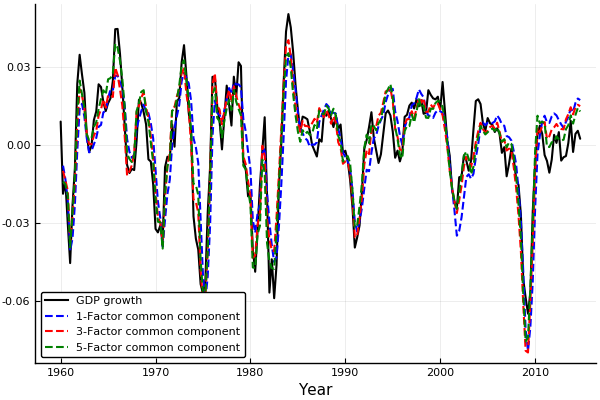

In [24]:
plot_skipmissing(year, hcat(y4, y4fs...), lw=1.5,
                lab=hcat("GDP growth", "1-Factor common component",
                        "3-Factor common component",
                        "5-Factor common component"),
                lc=[:black :blue :red :green],
                ls=[:solid :dash :dash :dash], 
                xlab="Year", leg=:bottomleft)

# Figure 5

In [25]:
function normalize_split_sample!(fac_f, fac_p)
    m_f = mean(skipmissing(fac_f[.!ismissing.(fac_p)]))
    s_f = std(skipmissing(fac_f[.!ismissing.(fac_p)]))
    m_p = mean(skipmissing(fac_p))
    s_p = std(skipmissing(fac_p))
    fac_p .= (fac_p .- m_p)*s_f/s_p.+m_p
end

normalize_split_sample! (generic function with 1 method)

In [26]:
dfmms = Vector{DFMModel}(undef, 3)
for i = 1:3
    periods = periodss[i]
    initperiod = find_row_number(periods[1], dataset.calds)
    lastperiod = find_row_number(periods[2], dataset.calds)
    dfmms[i] = DFMModel(data, inclcode,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
end
estimate_factor!.(dfmms)

3-element Array{Nothing,1}:
 nothing
 nothing
 nothing

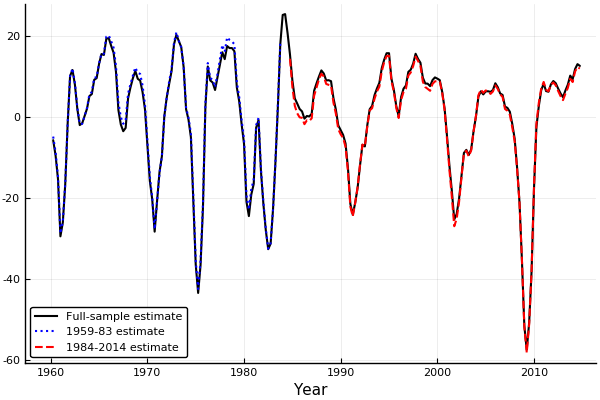

In [27]:
# plot first factor
i_fac = 1
f_full = dfmms[1].factor[:, i_fac]
f_pre = dfmms[2].factor[:, i_fac]
f_post = dfmms[3].factor[:, i_fac]
normalize_split_sample!(f_full, f_pre)
normalize_split_sample!(f_full, f_post)
y4fs = -detrended_year_growth.([f_full, f_pre, f_post])
plot_skipmissing(year, hcat(y4fs...), lw=1.5,
                lab=hcat("Full-sample estimate",
                         "1959-83 estimate",
                         "1984-2014 estimate"),
                lc=[:black :blue :red],
                ls=[:solid :dot :dash], 
                xlab="Year", leg=:bottomleft)

# Figure 6 (A)

In [28]:
periodss = (periods_all, periods_pre, periods_post)
facs = 1:10
trace_r2 = Matrix{Union{Missing, Float64}}(undef, length(facs), 3)
marg_r2 = Matrix{Union{Missing, Float64}}(undef, length(facs), 3)
ah_er = Matrix{Union{Missing, Float64}}(undef, length(facs), 3)
for (i, periods) = enumerate(periodss)
    initperiod = find_row_number(periods[1], dataset.calds)
    lastperiod = find_row_number(periods[2], dataset.calds)
    dfmm = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)

    fnes = estimate_factor_numbers(dfmm, facs)

    trace_r2[:, i] = 1 .- fnes.ssr_static./fnes.tss

    marg_r2[1, i] = trace_r2[1, i]
    marg_r2[2:end, i] = trace_r2[2:end, i] - trace_r2[1:end-1, i]
    ah_er[1:end-1, i] = marg_r2[1:end-1, i]./marg_r2[2:end, i]
end

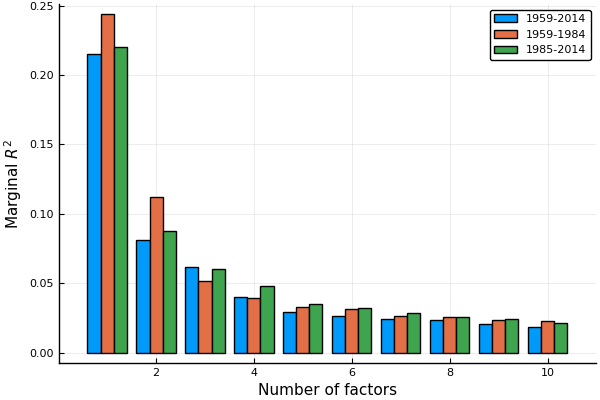

In [29]:
replace!(marg_r2, missing=>NaN)
groupedbar(facs, Float64.(marg_r2), lab=["1959-2014" "1959-1984" "1985-2014"],
           bar_position = :dodge, grid=true, 
           xlab="Number of factors",
           ylab=L"Marginal $R^2$")

# Figure 6 (B)

In [30]:
periodss = (periods_all, periods_pre, periods_post)
facs = 1:60
trace_r2 = Matrix{Union{Missing, Float64}}(undef, length(facs), 3)
for (i, periods) = enumerate(periodss)
    initperiod = find_row_number(periods[1], dataset.calds)
    lastperiod = find_row_number(periods[2], dataset.calds)
    for (j, nfac) in enumerate(facs)
        dfmm = DFMModel(data_all, inclcode_all,
              nt_min_factor_estimation, nt_min_factorloading_estimation,
              initperiod, lastperiod, nfac_o, nfac, tol, n_uarlag, n_factorlag)

        estimate_factor!(dfmm, 1, false)

        trace_r2[j, i] = 1 .- dfmm.fes.ssr./dfmm.fes.tss
    end
end

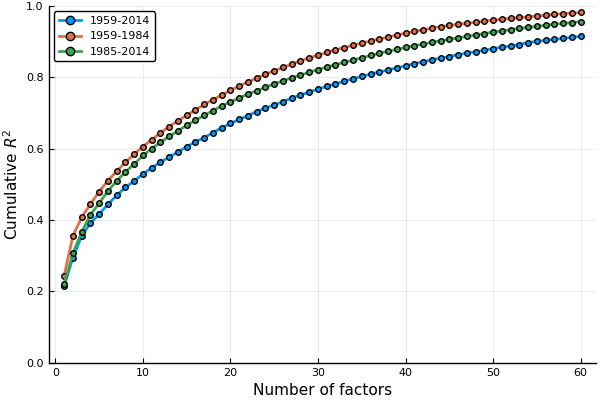

In [31]:
plot(trace_r2, lw=2, marker=:circle, 
     lab=["1959-2014" "1959-1984" "1985-2014"],
     ylim=(0,1), xlab="Number of factors", ylab=L"Cumulative $R^2$")

# Table 3 (A)

In [32]:
nfac_max = 10
r2 = Matrix{Any}(undef, length(inclcode_all), nfac_max)
initperiod = find_row_number((1959, 3), dataset.calds)
lastperiod = find_row_number( (2014, 4), dataset.calds)
for nfac_u in 1:nfac_max
    dfmm = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
    estimate!(dfmm)
    r2[:, nfac_u] = dfmm.r2
end

r2

207×10 Array{Any,2}:
 0.544717    0.612821    0.623122    …  0.812365   0.811433  0.838189
 0.365281    0.528363    0.621521       0.673346   0.683197  0.68656 
 0.230632    0.409233    0.441958       0.502886   0.511338  0.514002
 0.234675    0.268211    0.346146       0.414114   0.428018  0.434686
 0.206986    0.284485    0.342857       0.409178   0.411958  0.411567
 0.431982    0.453697    0.454353    …  0.636277   0.633606  0.642643
 0.663669    0.713164    0.724601       0.741229   0.743878  0.744266
 0.641542    0.643697    0.647351       0.678329   0.678746  0.679302
 0.658569    0.673797    0.674742       0.699399   0.702483  0.704035
 0.215357    0.51888     0.565694       0.583563   0.584251  0.593612
 0.323275    0.538735    0.550596    …  0.629207   0.651832  0.665965
 0.00153074  0.0032307   0.00759506     0.289832   0.279496  0.386368
 0.00963098  0.00992175  0.0106095      0.161965   0.181726  0.256985
 ⋮                                   ⋱                               

# Table 4(a)

In [33]:
initperiod = find_row_number((1959, 3), dataset.calds)
lastperiod = find_row_number((2014, 4), dataset.calds)
lastpreberiod = find_row_number((1984, 4), dataset.calds)
nfac_us = [4, 8]
levels = [0.99, 0.95, 0.9]
chow_rej_ratios = Matrix{Float64}(undef, length(levels), length(nfac_us))
qlr_rej_ratios = Matrix{Float64}(undef, length(levels), length(nfac_us))
cor_pres = Matrix{Float64}(undef, 5, length(nfac_us))
cor_posts = Matrix{Float64}(undef, 5, length(nfac_us))
qlr_thresh = Dict(4 => 4*[5.12 4.09 3.59], 8 => 8*[3.57 2.98 2.69])
for (ii, nfac_u) in enumerate(nfac_us)
    # estimate model using different sample periods
    dfmm = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
    dfmm_pre = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          initperiod, lastpreberiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
    dfmm_post = DFMModel(data_all, inclcode_all,
          nt_min_factor_estimation, nt_min_factorloading_estimation,
          lastpreberiod+1, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag)
    [estimate_factor!(m) for m in [dfmm, dfmm_pre, dfmm_post]]
    # pre allocation of outputs
    chow_stats = Vector{Union{Missing, Float64}}(undef, dfmm.ns)
    qlr_stats = Vector{Union{Missing, Float64}}(undef, dfmm.ns)
    cor_pre = Vector{Union{Missing, Float64}}(undef, dfmm.ns)
    cor_post = Vector{Union{Missing, Float64}}(undef, dfmm.ns)
    # allocate regressors
    X = dfmm.factor
    X_pre = dfmm_pre.factor
    X_post = dfmm_post.factor
    for i=1:dfmm.ns
        y = dfmm.data[:, i]
        yX_dropped, _ = drop_missing_row([y X])
        if (count(.!ismissing.(y[1:lastpreberiod])) >= 80) && (count(.!ismissing.(y[lastpreberiod+1:end])) >= 80)
            # compute Chow and QLR statistics using full sample
            chow_stats[i] = compute_chow(yX_dropped[:,1], yX_dropped[:, 2:end], 
                                         6, lastpreberiod)
            _, qlr_stats[i] = compute_qlr(yX_dropped[:,1], nothing,
                                          yX_dropped[:, 2:end], 0.15, 6)
            # compute fitted value with different sample period
            bhat, _, _ = ols_skipmissing(y, X, Balanced())
            yhat = X*bhat
            bhat, _, _ = ols_skipmissing(y, X_pre, Balanced())
            yhat_pre = X_pre*bhat
            bhat, _, _ = ols_skipmissing(y, X_post, Balanced())
            yhat_post = X_post*bhat
            # correlation of fitted value
            yhatyhatpre_dropped, _ = drop_missing_row([yhat yhat_pre])
            yhatyhatpost_dropped, _ = drop_missing_row([yhat yhat_post])
            cor_pre[i] = cor(yhatyhatpre_dropped[:, 1], yhatyhatpre_dropped[:, 2])
            cor_post[i] = cor(yhatyhatpost_dropped[:, 1], yhatyhatpost_dropped[:, 2])
        end
    end
    # Chow test uses chi square distribtuion
    d = Chisq(dfmm.nfac_t)
    # ratio of rejected chow test
    chow_rej_ratios[:, ii] = [count(skipmissing(chow_stats .> quantile(d, level)))/
                 count(.!ismissing.(chow_stats)) for level in levels]
    # ratio of rejected QLR test
    qlr_rej_ratios[:, ii] = [count(skipmissing(qlr_stats .> thresh))/
                 count(.!ismissing.(qlr_stats)) for (level, thresh) in zip(levels, qlr_thresh[nfac_u])]
    # correlations
    pct = [0.05, 0.25, 0.50, 0.75, 0.95]
    cor_pres[:, ii] = quantile(skipmissing(cor_pre), pct)
    cor_posts[:, ii] = quantile(skipmissing(cor_post), pct)
end

In [34]:
display([chow_rej_ratios[:, 1] qlr_rej_ratios[:, 1]])
display([chow_rej_ratios[:, 2] qlr_rej_ratios[:, 2]])
display([cor_pres[:, 1]'; cor_posts[:, 1]'])
display([cor_pres[:, 2]'; cor_posts[:, 2]'])

3×2 Array{Float64,2}:
 0.369318  0.619318
 0.534091  0.767045
 0.625     0.829545

3×2 Array{Float64,2}:
 0.522727  0.9375  
 0.664773  0.977273
 0.732955  0.977273

2×5 Array{Float64,2}:
 0.657909  0.887908  0.961714  0.986058  0.995812
 0.479358  0.833413  0.945956  0.974132  0.994274

2×5 Array{Float64,2}:
 0.595032  0.834459  0.92062   0.971703  0.989833
 0.431671  0.805298  0.940128  0.970165  0.985801

# Table 5

In [35]:
# Construct dataset with variables available over full-sample period
function choose_stepwise(dfmm, bpnamevec, initperiod, lastperiod)
    full_available_id = vec(all(.!ismissing.(dfmm.data[initperiod:lastperiod, :]), dims=1))
    data_avail = dfmm.data[:, full_available_id]
    bpnamevec_avail = bpnamevec[full_available_id]
    n_avail_series = size(data_avail, 2)
    X = Matrix{Union{Missing, Float64}}(undef, dfmm.T, dfmm.nfac_u)
    chosen_names = Vector{String}(undef, dfmm.nfac_u)
    candidates_i = collect(1:n_avail_series)
    for i = 1:dfmm.nfac_u
        r_tmp = Vector{Float64}(undef, n_avail_series+1-i)
        for (j, j_orig) in enumerate(candidates_i)
            X[:, i] = data_avail[:, j_orig]
            var=VARModel(X[:, 1:i], dfmm.factor_var_model.nlag;
                         withconst = dfmm.factor_var_model.withconst,
                         initperiod = dfmm.factor_var_model.initperiod,
                         lastperiod = dfmm.factor_var_model.lastperiod)
            estimate_var!(var, false)
            
            XandY, _ = drop_missing_col(
                        [var.resid dfmm.factor_var_model.resid]')
            M = fit(CCA, XandY[1:i, :],
                    XandY[i+1:end, :],
                    method=:svd, xmean=nothing, ymean=nothing)
            r_tmp[j] = correlations(M)[end]
        end
        r_max, r_max_i = findmax(r_tmp)
        X[:, i] = data_avail[:, candidates_i[r_max_i]]
        chosen_names[i] = bpnamevec_avail[candidates_i[r_max_i]]
        deleteat!(candidates_i, r_max_i)
    end
    return chosen_names
end

choose_stepwise (generic function with 1 method)

In [36]:
initperiod = find_row_number((1959, 3), dataset.calds)
lastperiod = find_row_number((2014, 4), dataset.calds)
nfac_u = 8
dfmm = DFMModel(data_all, inclcode_all,
                nt_min_factor_estimation, nt_min_factorloading_estimation,
                initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag);
estimate!(dfmm)
r_lev = 
varvars_dict = Dict("A"=>["GDPC96", "PAYEMS", "PCECTPI", "FEDFUNDS"],
                    "B"=>["GDPC96", "PAYEMS", "PCECTPI", "FEDFUNDS", 
                          "NAPMPRI", "WPU0561", "CP90_TBILL", "GS10_TB3M"],
                    "O"=>["OILPROD_SA", "GLOBAL_ACT", "WPU0561", "GDPC96",
                          "PAYEMS", "PCECTPI", "FEDFUNDS", "TWEXMMTH"],
                    "C"=>choose_stepwise(dfmm, dataset_all.bpnamevec, initperiod, lastperiod))
for var_type in keys(varvars_dict)
    var_vars = varvars_dict[var_type]
    # preallocation
    X = Matrix{Union{Missing, Float64}}(undef,
                    dfmm.T, length(var_vars))
    # grab variables included in VAR
    for (i, varvar) in enumerate(var_vars)
        j=findall(dataset_all.bpnamevec.==varvar)
        X[:, i] = dataset_all.bpdata[:, j]
    end
    
    # estimate VAR
    var=VARModel(X, dfmm.factor_var_model.nlag;
                 withconst = dfmm.factor_var_model.withconst,
                 initperiod = dfmm.factor_var_model.initperiod,
                 lastperiod = dfmm.factor_var_model.lastperiod)
    estimate_var!(var)
    
    # do Canonical correlation analysis
    XandY, _ = drop_missing_col([X dfmm.factor]')
    M = fit(CCA, XandY[1:length(var_vars), :],
            XandY[length(var_vars)+1:end, :],
            method=:svd, xmean=nothing, ymean=nothing)
    r_lev = correlations(M)

    # do Canonical correlation analysis
    XandY, _ = drop_missing_col([var.resid dfmm.factor_var_model.resid]')
    M = fit(CCA, XandY[1:length(var_vars), :],
            XandY[length(var_vars)+1:end, :],
            method=:svd, xmean=nothing, ymean=nothing)
    r_res = correlations(M)
    println("Table ", var_type)
    println(r_res')
    println(r_lev')
end

Table B
[0.828713 0.666405 0.593571 0.563533 0.36783 0.326967 0.175833 0.0128744]
[0.970849 0.953164 0.88717 0.827357 0.605005 0.43233 0.260839 0.102932]
Table A
[0.758897 0.644547 0.595399 0.492865]
[0.969612 0.85014 0.786959 0.574989]
Table C
[0.864272 0.811579 0.781995 0.758618 0.729628 0.582777 0.427683 0.3534]
[0.97923 0.928851 0.903055 0.869538 0.78742 0.77617 0.571982 0.414184]
Table O
[0.828561 0.795958 0.694211 0.556696 0.50433 0.2634 0.158947 0.0201914]
[0.976227 0.956039 0.876616 0.840232 0.715477 0.391099 0.179027 0.0153379]


# Figure 7

In [37]:
initperiod = find_row_number((1985, 1), dataset.calds)
lastperiod = find_row_number((2014, 4), dataset.calds)
nfac_u = 8
dfmm = DFMModel(data_all, inclcode_all,
                nt_min_factor_estimation, nt_min_factorloading_estimation,
                initperiod, lastperiod, nfac_o, nfac_u, tol, n_uarlag, n_factorlag);
# impose restriction
varnames = ["WPU0561", "MCOILWTICO", "MCOILBRENTEU", "RAC_IMP"]
R = Matrix{Float64}(I, dfmm.nfac_t, dfmm.nfac_t)
r = [1;zeros(dfmm.nfac_t-1)]
lam_constr_f = construct_constraint(varnames, 
                dataset_all.bpnamevec[findall(inclcode_all.==1)], R, r)
lam_constr_fl = construct_constraint(varnames, dataset_all.bpnamevec, R, r)
# estimate with the restriction
estimate!(dfmm, lam_constr_f=lam_constr_f, lam_constr_fl=lam_constr_fl)

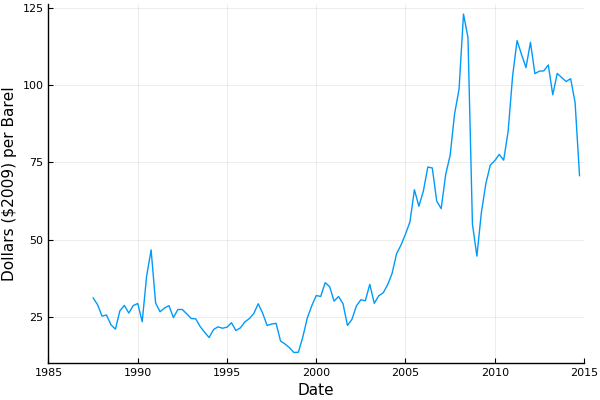

In [38]:
p = plot_skipmissing(year_all, 
    100*dataset_all.bpdata_raw[:, [findall(dataset_all.bpnamevec.=="MCOILBRENTEU")[1]]],
    xlabel="Date", ylabel="Dollars (\$2009) per Barel", xlim=(1985, 2015), label="")

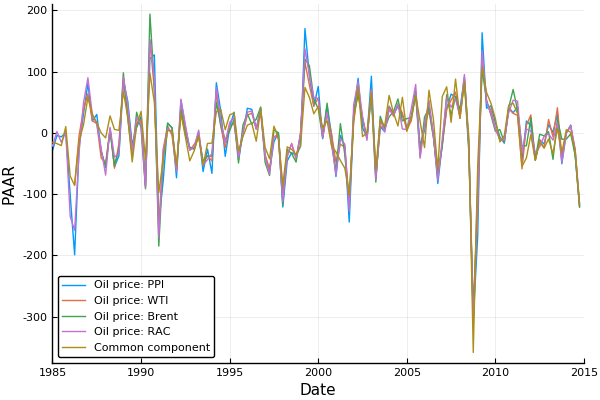

In [39]:
oilprice_id = [findall(dataset_all.bpnamevec.==varname)[1] for varname in varnames]

oilprice_data = data_all[:, oilprice_id]

p = plot_skipmissing(year_all, 400*[oilprice_data compute_series(dfmm, oilprice_id[1])],
    label=["Oil price: PPI"  "Oil price: WTI"  "Oil price: Brent" "Oil price: RAC" "Common component"],
    xlabel="Date", ylabel="PAAR", xlim=(1985, 2015))
